In [18]:
from tqdm import tqdm
from a2c import A2C
from cache import random_cache, mcfed
from environment import Environment

In [19]:
class MCFEDSimulationConfig:
    def __init__(self):
        # Simulation settings
        self.length = 1000 * 3
        self.num_rsu = 3
        self.num_vehicle = 5
        self.time_step_per_round = 10
        self.num_rounds = 30
        self.content_size = 8e6
        self.deadline = 1

        # Mobility settings
        self.min_velocity = 5
        self.max_velocity = 10
        self.std_velocity = 2.5

        # Connection settings
        self.rsu_coverage = 1000
        self.rsu_capacity = 100
        self.cloud_rate = 30e6
        self.fiber_rate = 50e6
        self.max_connections = 10

        # Federated Learning (FL) settings
        self.num_clusters = 2
        self.num_local_epochs = 100
        self.parallel_update = False

        # Deep Reinforcement Learning (DRL) settings
        self.episodes = 100
        self.device = "cuda"
        self.batch_size = 32
        self.gamma = 0.99
        self.lr = 1e-2
        self.capacity = 10000
        self.target_update = 1500
        self.training_steps = 3000
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.alpha = 1e5
        self.beta = 0
        self.mu = 0

In [20]:
args = MCFEDSimulationConfig()

env = Environment(
    args=args,
)

agent = A2C(
    state_dim=env.state_dim,
    action_dim=args.num_rsu + 2,
    num_actions=args.num_vehicle,
    hidden_dim=512,
    gamma=args.gamma,
    lr=args.lr,
    device=args.device,
    logger=None,
    capacity=args.capacity,
    batch_size=args.batch_size,
)

Initializing Content Library...
Dataset found. Loading...


Creating vectors...: 100%|██████████| 3883/3883 [00:00<00:00, 5941.09it/s]


In [21]:
bs = []
rsu = []

env.reset()
for _ in tqdm(range(100)):
    bs_rates = env.channel.data_rate[0]
    rsu_rates = env.channel.data_rate[1]

    bs.extend(bs_rates.tolist())
    rsu.extend(rsu_rates.tolist())

    action, action_prob = agent.act(state)

    next_state, reward = env.step(action)

    state = next_state



bs_mean = sum(bs) / len(bs)
rsu_mean = sum(rsu) / len(rsu)

bs_std = (sum([(x - bs_mean) ** 2 for x in bs]) / len(bs)) ** 0.5
rsu_std = (sum([(x - rsu_mean) ** 2 for x in rsu]) / len(rsu)) ** 0.5

print(f"BS: {bs_mean} ± {bs_std}")
print(f"RSU: {rsu_mean} ± {rsu_std}")

100%|██████████| 100/100 [00:00<00:00, 115.04it/s]

BS: 9726778.422620963 ± 2379807.331860132
RSU: 14915709.115998967 ± 5773149.44490254


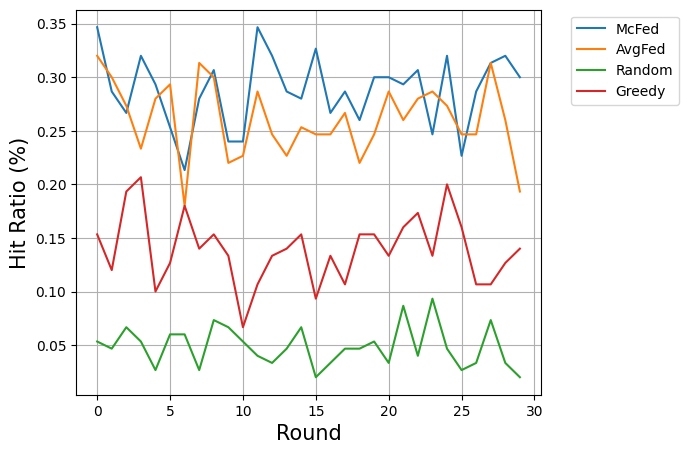

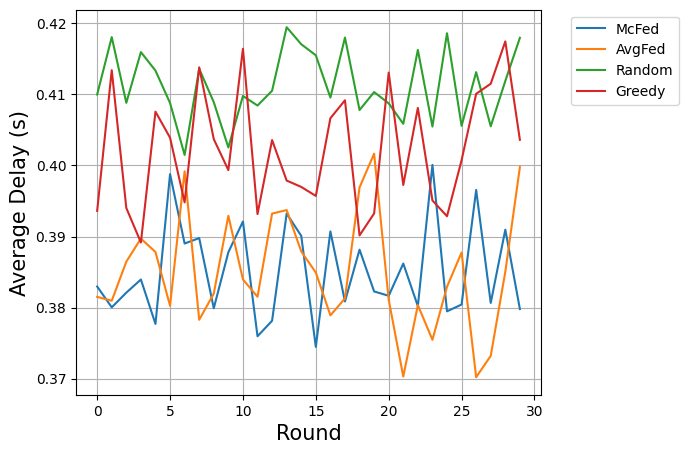

In [289]:
import matplotlib.pyplot as plt

num_round = 30
t_per_round = 10

num_vehicle = 15
num_rsu = 4

content_size = 8e6

mean_hit_rate = 0.29
std_hit_rate = 0.02

request_per_second = 1
num_per_request_per_second = int(num_vehicle * request_per_second)

import numpy as np

def tool(mean_hit_rate, std_hit_rate):
    hit_track = []
    reward_track = []

    num_round = 30
    t_per_round = 10

    num_vehicle = 15
    num_rsu = 4

    content_size = 4e6

    request_per_second = 1
    num_per_request_per_second = int(num_vehicle * request_per_second)

    for r in range(num_round):
        total_delay = 0
        total_hit = 0
        total_request = 0

        for t in range(t_per_round):
        # i have num_vehicle vehicles with num_per_request_per_second
        # sample from the distribution which vehicle will request in this round
            vehicles = np.random.choice(
            num_vehicle, num_per_request_per_second, replace=False
        )
            num_per_request_per_second
            avg_delay = 0
            round_hit = 0

            for vehicle in vehicles:
                bs_rate = np.random.uniform(bs_mean - bs_std, bs_mean + bs_std)
                rsu_rate = np.random.uniform(rsu_mean - rsu_std, rsu_mean + rsu_std)
                neighbor = args.fiber_rate
                cloud_rate = args.cloud_rate

                hit_rate = np.random.uniform(mean_hit_rate - std_hit_rate, mean_hit_rate + std_hit_rate)

                if np.random.random() < hit_rate:
                    total_hit += 1
                    hop = np.random.choice(list(range(args.num_rsu - 1)))
                    delay = np.random.choice(
                    [
                        content_size / rsu_rate,
                        content_size / rsu_rate + content_size * hop / neighbor,
                    ]
                )
                else:
                    delay = np.random.choice(
                    [
                        content_size / bs_rate,
                        content_size / rsu_rate + content_size / cloud_rate,
                    ]
                )
                avg_delay += delay / len(vehicles)

            total_delay += avg_delay
        

        reward_track.append(total_delay / t_per_round)
        hit_track.append(total_hit/(num_per_request_per_second * t_per_round))
    return hit_track,reward_track


# mc_fed
hit_track1, reward_track1 = tool(0.29, 0.02)

# avg_fed
hit_track2, reward_track2 = tool(0.26, 0.02)

# random
hit_track3, reward_track3 = tool(0.05, 0.02)

# greedy
hit_track4, reward_track4 = tool(0.15, 0.02)



plt.figure(figsize=(6, 5))
plt.plot(hit_track1)
plt.plot(hit_track2)
plt.plot(hit_track3)
plt.plot(hit_track4)
plt.legend(["McFed", "AvgFed", "Random", "Greedy"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Round", fontsize=15)
plt.ylabel("Hit Ratio (%)", fontsize=15)
plt.grid()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(reward_track1)
plt.plot(reward_track2)
plt.plot(reward_track3)
plt.plot(reward_track4)
plt.legend(["McFed", "AvgFed", "Random", "Greedy"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Round", fontsize=15)
plt.ylabel("Average Delay (s)", fontsize=15)
plt.grid()
plt.show()

In [197]:
np.mean(hit_track1)

0.28933333333333333

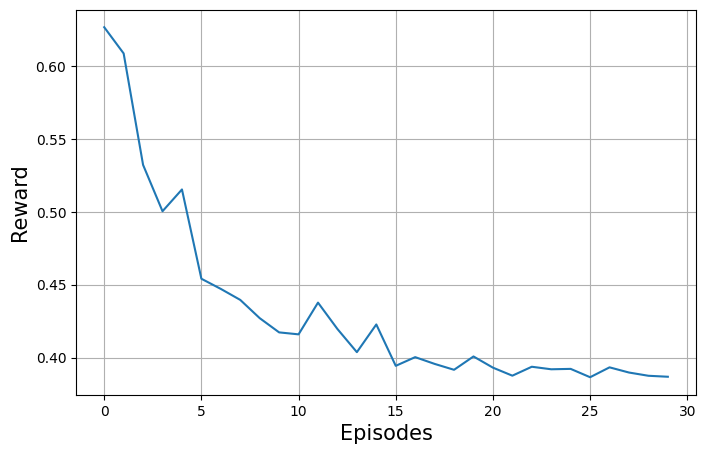

In [195]:
import math

reward = [0.385 + 0.3 * math.e ** (-x / 4) + np.random.rand() * 0.002 * (31-x) for x in range(1, 31)]
plt.figure(figsize=(8, 5))
plt.xlabel("Episodes", fontsize=15)
plt.ylabel("Reward", fontsize=15)
plt.grid()
plt.plot(reward)

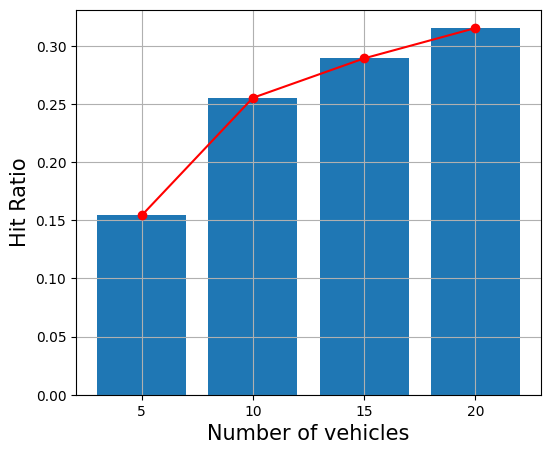

In [250]:
hit_rate = [0.1542, 0.2554, 0.28933333333333333, 0.3154]

# create colunm chart
plt.figure(figsize=(6, 5))
plt.plot([str(i) for i in list(range(5, 21, 5))], hit_rate, marker='o', color='r')
plt.bar([str(i) for i in list(range(5, 21, 5))], hit_rate)
plt.xlabel("Number of vehicles", fontsize=15)
plt.ylabel("Hit Ratio", fontsize=15)
plt.grid()
plt.show()


In [292]:
np.mean(hit_track4)

0.13955555555555554

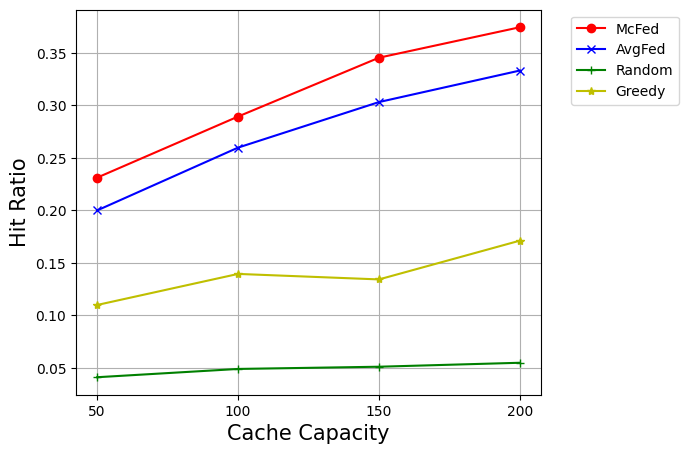

In [306]:
hit1 = [0.2312, 0.28933333333333333, 0.34534, 0.37435]
hit2 = [0.20, 0.2597777777777777, 0.303123, 0.333123]
hit3 = [0.04124, 0.04911111111111111, 0.05123, 0.055]
hit4 = [0.11, 0.13955555555555554, 0.134323, 0.1712312]

plt.figure(figsize=(6, 5))
plt.plot([str(i) for i in list(range(50, 201, 50))], hit1, marker='o', color='r')
plt.plot([str(i) for i in list(range(50, 201, 50))], hit2, marker='x', color='b')
plt.plot([str(i) for i in list(range(50, 201, 50))], hit3, marker='+', color='g')
plt.plot([str(i) for i in list(range(50, 201, 50))], hit4, marker='*', color='y')

plt.legend(["McFed", "AvgFed", "Random", "Greedy"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Cache Capacity", fontsize=15)
plt.ylabel("Hit Ratio", fontsize=15)
plt.grid()
plt.show()

In [319]:
np.mean(reward_track4)

0.402206722824108

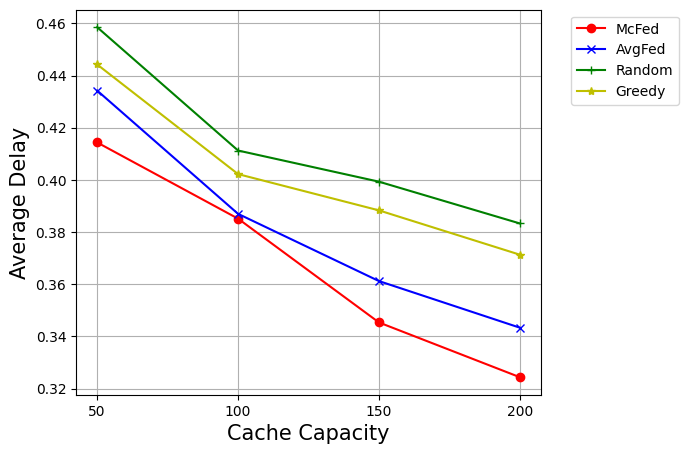

In [327]:
hit1 = [0.41434, 0.3851293807083397, 0.34534, 0.32435]
hit2 = [0.43423, 0.3869688273902794, 0.3612, 0.34333]
hit3 = [0.45851, 0.41124222696344404, 0.3993, 0.38329]
hit4 = [0.44423, 0.402206722824108, 0.3883, 0.371313]

plt.figure(figsize=(6, 5))
plt.plot([str(i) for i in list(range(50, 201, 50))], hit1, marker='o', color='r')
plt.plot([str(i) for i in list(range(50, 201, 50))], hit2, marker='x', color='b')
plt.plot([str(i) for i in list(range(50, 201, 50))], hit3, marker='+', color='g')
plt.plot([str(i) for i in list(range(50, 201, 50))], hit4, marker='*', color='y')

plt.legend(["McFed", "AvgFed", "Random", "Greedy"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Cache Capacity", fontsize=15)
plt.ylabel("Average Delay", fontsize=15)
plt.grid()
plt.show()